In [26]:
import numpy as np 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras import layers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


## Data Collection and Analysis


In [27]:
dataset = pd.read_csv('Tesla.csv')


### DataFrame

In [28]:
dataset.head()

,Unnamed: 0,Date,Open,High,Low,Close,Volume
0,0,2015-01-02,14.858000,14.883333,14.217333,14.620667,71466000
1,1,2015-01-05,14.303333,14.433333,13.810667,14.006000,80527500
2,2,2015-01-06,14.004000,14.280000,13.614000,14.085333,93928500
3,3,2015-01-07,14.223333,14.318667,13.985333,14.063333,44526000
4,4,2015-01-08,14.187333,14.253333,14.000667,14.041333,51637500


In [29]:
dataset.tail()

,Unnamed: 0,Date,Open,High,Low,Close,Volume
2269,2269,2024-01-09,238.110001,238.960007,232.039993,234.960007,96705700
2270,2270,2024-01-10,235.100006,235.500000,231.289993,233.940002,91628500
2271,2271,2024-01-11,230.570007,230.929993,225.369995,227.220001,105873600
2272,2272,2024-01-12,220.080002,225.339996,217.149994,218.889999,122889000
2273,2273,2024-01-16,215.100006,223.490005,212.180099,219.910004,115064708


In [30]:
dataset.dtypes

Unnamed: 0      int64
Date           object
Open          float64
High          float64
Low           float64
Close         float64
Volume          int64
dtype: object

In [31]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2274 entries, 0 to 2273
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  2274 non-null   int64  
 1   Date        2274 non-null   object 
 2   Open        2274 non-null   float64
 3   High        2274 non-null   float64
 4   Low         2274 non-null   float64
 5   Close       2274 non-null   float64
 6   Volume      2274 non-null   int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 124.5+ KB


In [32]:
dataset.describe()

,Unnamed: 0,Open,High,Low,Close,Volume
count,2274.000000,2274.000000,2274.000000,2274.000000,2274.000000,2.274000e+03
mean,1136.500000,103.493730,105.771617,101.036327,103.461794,1.142089e+08
std,656.591578,111.136174,113.606095,108.399966,111.032019,7.688430e+07
min,0.000000,9.488000,10.331333,9.403333,9.578000,1.062000e+07
25%,568.250000,16.669833,16.933332,16.468833,16.693666,6.637762e+07
50%,1136.500000,23.221334,23.554000,22.842334,23.197333,9.359855e+07
75%,1704.750000,215.272503,219.629173,208.983334,215.227497,1.338214e+08
max,2273.000000,411.470001,414.496674,405.666656,409.970001,9.140820e+08


In [33]:
# Detect missing values
if (dataset.isnull().sum().sum() != 0):
    dataset.fillna(method='ffill', inplace=True)

# Check again for missing values
print(dataset.isnull().sum())

Unnamed: 0    0
Date          0
Open          0
High          0
Low           0
Close         0
Volume        0
dtype: int64


In [34]:
# Count duplicate rows
if (dataset.duplicated().sum() != 0):
    # Remove duplicate rows
    dataset.drop_duplicates(inplace=True)

# Check again for duplicate rows
print(dataset.duplicated().sum())

0


## Data Preprocessing

### Setting datetime

In [35]:
# Setting the 'Date' as the index of the DataFrame
# Useful for plotting time series data for ordering and slicing
dataset.index = pd.to_datetime(dataset['Date'])
dataset.drop(columns=['Date'], inplace=True)
dataset.drop(columns=['Unnamed: 0'])


,Open,High,Low,Close,Volume
Date,,,,,
2015-01-02,14.858000,14.883333,14.217333,14.620667,71466000
2015-01-05,14.303333,14.433333,13.810667,14.006000,80527500
2015-01-06,14.004000,14.280000,13.614000,14.085333,93928500
2015-01-07,14.223333,14.318667,13.985333,14.063333,44526000
2015-01-08,14.187333,14.253333,14.000667,14.041333,51637500
...,...,...,...,...,...
2024-01-09,238.110001,238.960007,232.039993,234.960007,96705700
2024-01-10,235.100006,235.500000,231.289993,233.940002,91628500
2024-01-11,230.570007,230.929993,225.369995,227.220001,105873600


### Dividing into training and test datasets

In [36]:
# Determine the split point based on the 75-25 split
split_date = dataset.index[int(len(dataset) * 0.75)]

# Splitting the data into training and testing sets
train = dataset[dataset.index < split_date]
test = dataset[dataset.index >= split_date]

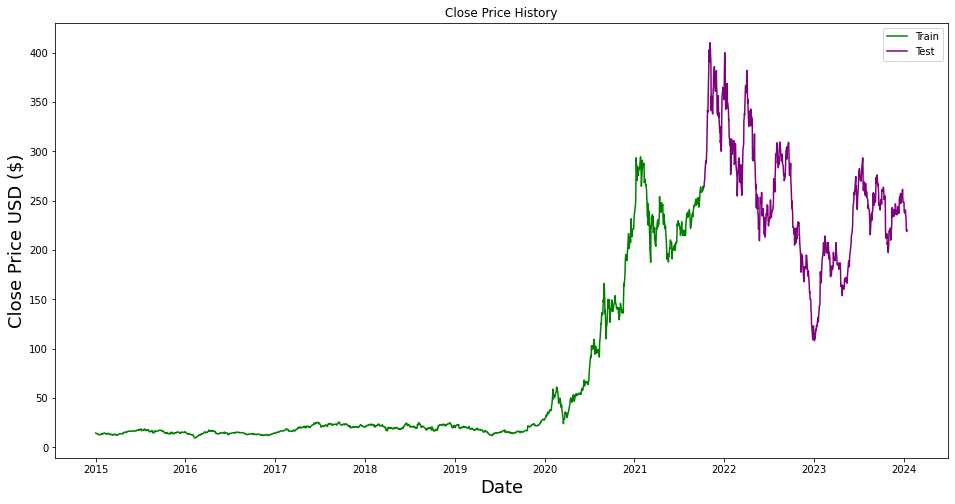

In [37]:
# Visualizing the Closing Price History
plt.figure(figsize=(16,8))
plt.plot(train['Close'], label='Train', color='green')
plt.plot(test['Close'], label='Test', color='purple')
plt.legend()
plt.title('Close Price History')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

### Feature Scaling
Normalize the input data before feeding it to an LSTM model. Normalization helps to scale the data and make it easier for the LSTM to learn. Translate the features between zero and one.

In [38]:
# Normalizing the dataset
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(train['Close'].values.reshape(-1, 1))

In [39]:
# Hyperparameters
batch_size = 32
epochs = 100

# Creating sequences
X_train, y_train = [], []
for i in range(80, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-80:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [40]:
# Splitting into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

### Reshaping datasets
Reshape the data before feeding it to an LSTM model

In [41]:
# Reshaping for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

## LSTM Model

In [42]:
# Building the model
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(units=50, return_sequences=True),
    Dropout(0.2),
    LSTM(units=50, return_sequences=True),
    Dropout(0.2),
    LSTM(units=50),
    Dropout(0.2),
    Dense(units=1),
])


model.compile(optimizer='adam',loss='mse', metrics=['mse', 'mae', 'mape'])

c:\Users\nihal\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [43]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 80, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 80, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 80, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 80, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 80, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 80, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,051 (277.54 KB)

 Trainable params: 71,051 (277.54 KB)

 Non-trainable params: 0 (0.00 B)

### Fitting the model

In [44]:
# early_stopping = callbacks.EarlyStopping(
#     patience=10,
#     min_delta=0.001,
#     restore_best_weights=True,
# )

# Training the model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 157ms/step - loss: 0.0285 - mae: 0.1007 - mape: 180.5410 - mse: 0.0285 - val_loss: 0.0041 - val_mae: 0.0551 - val_mape: 123448.3047 - val_mse: 0.0041
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - loss: 0.0047 - mae: 0.0414 - mape: 70.9885 - mse: 0.0047 - val_loss: 0.0013 - val_mae: 0.0253 - val_mape: 11081.5459 - val_mse: 0.0013
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - loss: 0.0029 - mae: 0.0306 - mape: 51.4705 - mse: 0.0029 - val_loss: 0.0026 - val_mae: 0.0302 - val_mape: 3660.1206 - val_mse: 0.0026
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - loss: 0.0036 - mae: 0.0325 - mape: 42.7007 - mse: 0.0036 - val_loss: 0.0013 - val_mae: 0.0197 - val_mape: 5126.8398 - val_mse: 0.0013
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - loss: 0.0026 - mae: 0.0256 - mape: 32.9707 - mse: 0.0026 - val_loss: 0.0011 - val_mae: 0.0232 - val_mape: 12167.7764 - val_mse: 0.0011
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/s

### Validation
#### Metrics:
- Mean squared error (MSE) - the average squared difference between the predicted values and the actual values.
- Mean absolute error (MAE) - the average absolute difference between the predicted values and the actual values
- Mean absolute percentage error (MAPE) - calculates the percentage difference between the predicted values and the actual values, and then averages these percentage differences

In [45]:
history_frame = pd.DataFrame(history.history)

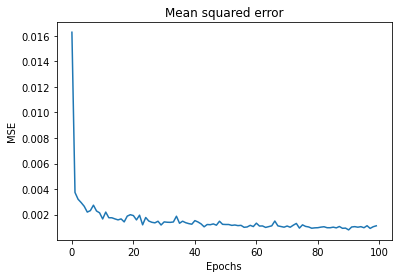

In [57]:
plt.plot(history_frame.loc[:, ['mse']])
plt.title('Mean squared error')
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.show()

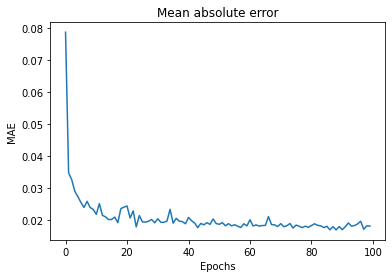

In [58]:
plt.plot(history_frame.loc[:, ['mae']])
plt.title('Mean absolute error')
plt.ylabel('MAE')
plt.xlabel('Epochs')
plt.show()

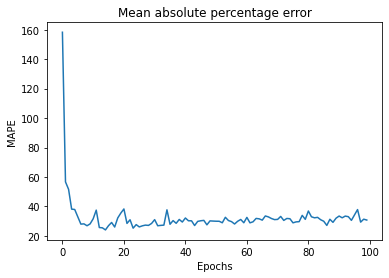

In [59]:

plt.plot(history_frame.loc[:, ['mape']])
plt.title('Mean absolute percentage error')
plt.ylabel('MAPE')
plt.xlabel('Epochs')
plt.show()

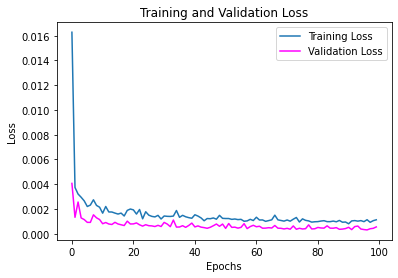

In [49]:
# Plotting the training history
plt.plot(history_frame['loss'], label='Training Loss')
plt.plot(history_frame['val_loss'], label='Validation Loss', color='magenta')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Predictions

In [50]:
dataset_total = dataset['Close']
inputs = dataset_total[len(dataset_total)-len(test['Close'].values) - 80:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [51]:
X_test = []
for i in range(80, len(inputs)):
    X_test.append(inputs[i-80:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


In [52]:
predictions = pd.DataFrame()
predictions['Actuals'] = test['Close']
predictions['Predictions'] = predicted_stock_price

## Visualising Predictions

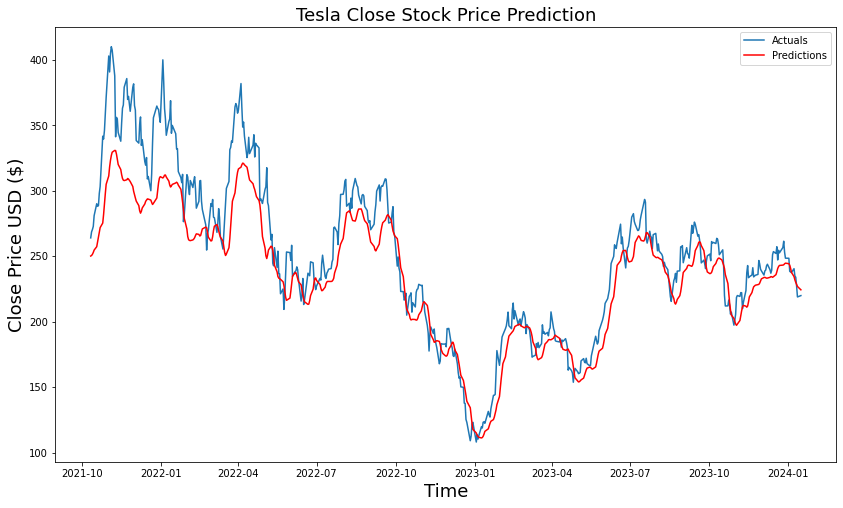

In [53]:
plt.figure(figsize=(14,8))
plt.title('Tesla Close Stock Price Prediction', fontsize=18)
plt.plot(predictions['Actuals'], label='Actuals')
plt.plot(predictions['Predictions'], label='Predictions', color='red')
plt.xlabel('Time',fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.legend()
plt.show()

## Accuracy

In [54]:
score = r2_score(predictions['Actuals'],predictions['Predictions'])
print(f'r2 score: {score}')

r2 score: 0.8189363326138708


In [55]:
# Error Analysis
mse = mean_squared_error(predictions['Actuals'], predictions['Predictions'])
mae = mean_absolute_error(predictions['Actuals'], predictions['Predictions'])
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')


Mean Squared Error: 688.6347331222196
Mean Absolute Error: 19.32946820250714


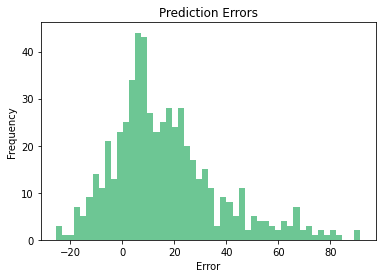

In [56]:
# Plotting errors
errors = predictions['Actuals'] - predictions['Predictions']
plt.hist(errors, bins=50, alpha=0.75, color='mediumseagreen')
plt.title('Prediction Errors')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()